In [54]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import numpy
import scipy
import random
import matplotlib as mpl
import pylab as plt
import time
import numba
import itertools
import math
#
import multiprocessing as mpp
import multiprocess as mp
#
import calc_pi as cp
import calc_mandelbrot as cmb
#

# Python: (some) best practices, optimizations, and parallelization

# Calculate Pi

(Content borrowed shamelessly from SW Carpentry, [https://www.hpc-carpentry.org/hpc-parallel-novice/04-mapreduce-of-files/index.html].

Here, we demonstrate an area based, Reno-Nevada (poor person's Monte Carlo) method to estimate $pi$. We draw random numbers over a square with sides $L = 2R = 2$ and count the fraction of points that fall inside an enclosed circle with radius $R$. Eventually we will add a figure.

The gist of the formula is,

$\frac{N_{captured}}{N_{total}} = \frac {\pi R^2}{(2R)^2}$


Use this little PI calculator to illustrate methods of optimnization and parallelization. These will include:

1. Loop-loop (nested loop), which is a trainwreck for Python...
2. @numba.jit the loop-loop
3. Vectorize the random numbers
4. Parallelize various ways.
  1. Process() ?
  2. multiprocessing.Pool().map() ( and variants)
  3. mpi4py ?
  4. Embarrasingly parallel approach?



### First draft implementation
- Start with the simplest implementation
- NOTE: this is generally speaking a pretty terrible way to use Python
- But it illustrates all the main things.
- We will discuss how to improve it later.

In [56]:

# The base function:
def calc_pi_nogil(N):
    M = 0
    for i in range(int(N)):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 < 1:
            M += 1
    return 4 * M / N

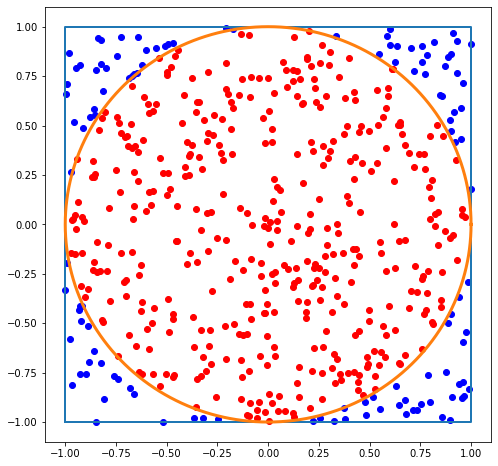

In [57]:
def draw_circle(R=1, N=1000):
    thetas = numpy.linspace(0., 2.*math.pi, N+1)
    #return numpy.array([(x,y) for x,y in zip(numpy.cos(thetas), numpy.sin(thetas))],
    #                  dtype=[('x','<f8'), ('y', '<f8')])
    return numpy.array([numpy.cos(thetas), numpy.sin(thetas)]).T
#
fg = plt.figure(figsize=(8,8))
ax = fg.add_subplot(1,1,1)
#
R = 1.
circ = draw_circle(R=R)
samples = numpy.random.random((550,2))*2.*R - R
ix = numpy.sum(samples*samples, axis=1) < (R*R)

ax.plot(R*numpy.array([-1., 1., 1., -1., -1.]), R*numpy.array([-1., -1., 1., 1., -1.]), lw=2)
ax.plot(*circ.T, lw=3)
ax.scatter(*(samples[ix]).T, marker='o', color='r')
ax.scatter(*(samples[numpy.invert(ix)]).T, marker='o', color='b')


### Benchmark this function for $N$

In [159]:
# This is the simplest, most straight forward calculation.
#
t1 = time.time()
PIs = []
for N_max in numpy.arange(1E3, 1E5, 1E4):
    #print(f'*** Computing Pi for {N_max}')
    t0=time.time()
    PIs += [[N_max, calc_pi_nogil(int(N_max)), time.time()-t0]]
dt_ll = time.time()-t1
print(f'** dt: {dt_ll}')
#
print('** Pi vals: ')
for n,pi,t in PIs:
    print(f'{n} :: {pi} :: {t}')
#


** dt: 0.33787012100219727
** Pi vals: 
1000.0 :: 3.156 :: 0.001239776611328125
11000.0 :: 3.142181818181818 :: 0.008388042449951172
21000.0 :: 3.1342857142857143 :: 0.016775131225585938
31000.0 :: 3.148516129032258 :: 0.02276897430419922
41000.0 :: 3.1382439024390245 :: 0.02943897247314453
51000.0 :: 3.1381960784313727 :: 0.03671908378601074
61000.0 :: 3.1357377049180326 :: 0.043524980545043945
71000.0 :: 3.1460845070422536 :: 0.050486087799072266
81000.0 :: 3.132888888888889 :: 0.05853009223937988
91000.0 :: 3.1434285714285712 :: 0.06663393974304199


## Some optimizations


## List comprehensions

A list comprehension is a more compact, some will say more intuitive and readable (others will disagree with one or more of those characteriztions) way to construct a list in Python. List comprehensions are usually faster than aggregating,  or even creating a list to size and assiging values (ie, PIs=list(NN_max) vs PIs=[]), albeit not always significantly.

But note that it can be difficult or not possible to do more complex, multi-step actions in a list comprehension.

In [59]:
# List comprehension way (a little bit faster...)
# this:
# X = []
# for k in range(n):
#     X+=[f(k)]
# becomes:
# X = [f(k) for k in range(n)]
#
t1 = time.time()
PIs = [[N_max, calc_pi_nogil(int(N_max))] for N_max in numpy.arange(1E3, 1E5, 1E4)]
print(f'** dt: {time.time()-t1}')
#
print('** Pi vals: ')
for n,pi in PIs:
    print(f'{n} :: {pi}')
#


** dt: 0.33538174629211426
** Pi vals: 
1000.0 :: 3.088
11000.0 :: 3.1498181818181816
21000.0 :: 3.121142857142857
31000.0 :: 3.1472258064516128
41000.0 :: 3.1406829268292684
51000.0 :: 3.136
61000.0 :: 3.1451147540983606
71000.0 :: 3.1429295774647885
81000.0 :: 3.1301234567901233
91000.0 :: 3.1458461538461537


## Vectorization
- Probably first, most reliable and stable optimization
- Pass a sequence (vector) of values to the processor, rather than one variable at a time
- Makes _MUCH_ better use of the processers cache(s)
- Often simplified syntax _AND_ much improved performance.

Let's rewrite calc_pi(), a little more creatively.


In [60]:
def calc_pi_vec(N):
    #M = 0
    # spell it out, then consolidate...
    #X = 2. * numpy.random.random(N) - 1.
    #Y = 2. * numpy.random.random(N) - 1.
    #Z = X**2 + Y**2
    #
    # All of that in one line...
    # You should experiment with some of this syntax to evaluate performance.
    # this looks much faster than numpy.square()
#    Z = numpy.sum( numpy.random.uniform(-1., 1., (2,N) )**2. , axis=0 )
#    #Z = numpy.sum( numpy.square( numpy.random.uniform(-1.,1., (2,N) ) ), axis=0 )
#    #
#    # as a little trick, sum the index of (Z<1)
#    M = numpy.sum((Z<1))
    
    #M = numpy.sum( (numpy.sum( numpy.random.random( (2,N) )**2. , axis=0 ))<1 )
    M = numpy.sum( (numpy.sum( numpy.random.uniform(-1,1, (2,N) )**2. , axis=0 ))<1 )
    #
    return 4.0*M/N


## numba
- Use `@jit` to pre-compile the function.
- This often works _REALLY_ well for simple, just-math functions. Numpy containers, internal functions, etc. have potential to confuse `numba`
- So numba is often a way to make a really bad code (eg, a loop-loop), really good, but it can be complicated to make a pretty-good code much better.
- `numba` also has some compile-time options, which we will show below. These include:
  - Releasing the `GIL`
  - (almost!) Automagical parallelization (much like `parfor`)
- `numba` can be annoying to work with. There are cases where it will generate loads of warning messages, which are difficult to suppress.
- You have to be realy careful to keep your parallel codes thread-safe


In [61]:
## Compile with Numba:
#
@numba.jit()
def calc_pi_1(N):
    M = 0
    for i in range(int(N)):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 < 1:
            M += 1
    return 4 * M / N

@numba.jit(nopython=True)
def calc_pi_2(N):
    M = 0
    for i in range(int(N)):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 < 1:
            M += 1
    return 4 * M / N

@numba.jit(nopython=True, nogil=True)
def calc_pi_3(N):
    M = 0
    for i in range(int(N)):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 < 1:
            M += 1
    return 4 * M / N
#
# How 'bout this?
@numba.njit(parallel=True)
def calc_pi_njp(N):
    M = 0
    for i in numba.prange(int(N)):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 < 1:
            M += 1
    return 4. * M / N

## Benchmark
- Compare performance for loop-loop, vectorization, and versions of `numba.jit`
- Note that `numba.jit` performs much better for this example. 
- There are likely some subtlties in the vectorization that can be resolved, but...
- Mostly, this is because our kernel functions are just pure Python math, which are put through a simple loop If there were other libries included in those functions, eg. `random.random()` let alone anything `numpy`, `numba` would likely throw a bunch of warnings and the acceleration would be reduced.

### Comments on benchmarking:
- Straight forward(ish), but can be tricky! Some things to look out for...
- SW or HW solutions that "help" by cacheing results (maybe chanbe up the problem a little bit?)
- For `numba` (and other optimizers), run a small job first, to be sure the code compiles
- Is there some other overhead affecting your benchmark?
- `%timeit` is pretty awesome, but beware artifacts from overhead...
- Is your computer doing other things too?
- Understand the problem and the code and stategize accordingly. Eg, is `range(10E7)` equivalent (better?) than `[f(10E7) for k in range(10)]`


In [160]:
# try the different jit-compile options:
#
N_max=1E7
for f in (cp.calc_pi_loop_loop, cp.calc_pi_vec, cp.calc_pi_jit,\
          cp.calc_pi_jit_np, cp.calc_pi_jit_ng, cp.calc_pi_jit_ng_np,\
         calc_pi_njp):
    # 
    # do a quick run, so we dont' count compile time.
    dummy_var = f(500)
    t1 = time.time()
    #PIs = [[N_max, f(int(N_max))] for N_max in numpy.arange(1E3, 1E5, 1E4)]
    pi = f(int(N_max + random.randint(1,10)))
    print(f'f = {f.__name__}')
    print(f'** dt: {time.time()-t1}')
    print(f'** pi: {pi}\n')
    #
#     print('** Pi vals: ')
#     for n,pi in PIs:
#         print(f'{n} :: {pi}')

f = calc_pi_loop_loop
** dt: 7.657015085220337
** pi: 3.1420424857957516

f = calc_pi_vec
** dt: 0.3619840145111084
** pi: 3.1413718869024905

f = calc_pi_jit
** dt: 0.10786294937133789
** pi: 3.141949457415163

f = calc_pi_jit_np
** dt: 0.10567212104797363
** pi: 3.141835572347985

f = calc_pi_jit_ng
** dt: 0.10482406616210938
** pi: 3.142290057709942

f = calc_pi_jit_ng_np
** dt: 0.10825014114379883
** pi: 3.141726343309463

f = calc_pi_njp
** dt: 0.033171892166137695
** pi: 3.1411662576501227



## `numba` parallel
- Note the `numba.njit(parallel=True)` compilation/decoration example above.
- For simple loops, this may be about as good as it gets
- But as discussed, its applicaiton may be limited, and you have to be careful.


## Embarrasingly parallel
- Kind of a dumb example, unless we make the problem much bigger. Maybe Mandelbrot?
- Alas... The idea is to run many independent instances, then separately collect and aggregate.
- Consider a wrapper functoin:
```
    def calc_pi_n_write(f_pi=calc_pi_jit_np, Nits=int(1E7), fout_name=None):
    '''
    # comput pi and output to fout. We will use this as a simple demonstrator of emb. parallal.
    '''
    pi = f_pi(Nits)
    #
    if not fout_name is None:
        with open(fout_name, 'a') as fout:
            fout.write(f'pi:{pi}\n')
    return pi
```
- Which we can submit to the scheduler with something like this:
```
    #!/bin/bash
    #
    #SBATCH --job-name=e-p_compute_pi
    #SBATCH --output=comp_pi.out
    #SBATCH --error=comp_pi.err
    #SBATCH --mem-per-cpu=1g
    #SBATCH --cpus-per-task=1
    #SBATCH --ntasks=1
    #SBATCH --partition=serc,normal,owners
    #SBATCH --time=00:10:00
    #
    module purge
    #module load python/3.9
    #module load py-sherlock/
    module load anaconda/3.11
    #
    PI_OUTPUT=ep_pi.csv
    #
    python3 -c "import calc_pi as cp;cp.calc_pi_n_write(fout_name='${PI_OUTPUT}')"
```
- We can submit/run multiple instances by either:
  - Submitting a whole bunch of individual jobs: This is sloppy, hard on the scheduler, and will make Kilian angry.
  - Job array (eg, `--array=0-100%10`): This is usually optimal. We can submit LOTS of instances, but still control concurrent resource use with the `%` operator.
    - `sbatch --array=0-16 e_paralell_pi.sh `
  - `--ntasks`: This is not really what `--ntasks` was meant to do, but it will work. In this case, it will launch `--ntasks` instances, simultaneously and running in parallel.
    - `sbatch --ntasks=16 e_paralell_pi.sh `
 
 

## Parallel compute: Multiprocessing
Parallel computation in Python is fundamentally limited by the Global Interpreter Lock (GIL), which basically limits Python to do one thing at a time. You can, for example, launch tasks as threads -- which in other envoronments might be allowed to run in parallel, but in Python, those threads run sequentially.

There are two basic approaches to working around the GIL:
1. Use (compiled) components that operate in parallel -- but appear effectively serial to Python
2. Launch multiple instances of Python

There are numerous examples of the first case. We have already seen that `numba` can do this. we also see this in many compilations of `numpy` matrix algebra. The built in Python module `multiprocessing` takes the second approach. Though it is limited to a single machine, `multiprocessing` in some ways resembles an MPI framework -- a comput job is broken up into pieces, then "pickled" (serialized) and run as independent processes; the GIL is maintained in each separeat thread.

The main disadvantages of `multiprocessing` is that there is relatively high compute and memory overhead -- since the entire process has to be copied, and it can be programmatically complicated (nominally, simpler than most MPI programs, but more difficult than `parfor`). Another disadvantage is that -- as mentioned, it is limited to a single machine.

On that latter note, consider the cousin library, `multiprocess` -- more or less a copy of `multiprocessing` that includes several multi-node options -- eg, an MPI capagle `Pool()` class. Note that multiprocessing, and especially MPI, or other multi-node capable options, appear to be a very active work in progress at this time (Oct 2023), so there might be other good options available (see for example `pip install mpipool`... I think).

For now we focus on `multiprocessing`. Some of the salient components include:

- Process(): The simplest example, nominally applies well to this example
- Pool(): Sort of a dumb way to use a Pool(), but we're in the business of making examples
- Queue(): I've never used a queueu, but...

**NOTE:** Multiprocessing (`mpp`) will (often) _not_ work (well) in notebooks. Parallelized functions must be off-loaded to a .py module, so that the function can be referenced by an separate Python instance when it is serialized. Note that you can run `mpp` elements (`Pool()`, `Process()`, `pipe()`) from notebooks -- so long as the `target` function is externally defined. Even with this caveat however, some `mpp` elements may not work well, or multiprocessing jobs might be prone to memory leaks (especially during develompent, when they can fail), or `mpp` instances may simply perform sub-optimally in notebooks. So... beware and benchmark accordingly!


## MPP structural elements
- Pipe()
- Process()
- Pool()
- Other things too...
- (NOTE: these codes are reproduced in an external module so they can be run in parallel).


1) Rewrite `calc_pi()` to return data via a `Pipe()`
2) Generalize this with a wrapper function that accepts a function `f` as a parameter.

NOTE: these examples may not actually parallelize, but we show examples of how to use the `Process()` class and varying levels of functional abstraction -- in other words, do I modify my code to be compatible with `Process()`, or do I use a wrapper function? 

In [196]:
# MPP Process()
#. it is possible that the syntax for this has changed, which is to say that this attempt and even the 
#. line-for-line example from the docs does not appear to run. 
# Note that these codes will not run in parallel, but their off-notebook counterparts will.
#
# Sometimes, there are lots of wrapper functions in parallel Python programming.

# 1) Rewrite the calc_pi() function to use a pipe, instead of a `return` statement (or in this case, both)
def calc_pi_pipe(N, conn):
    '''
    # A simple demonstration of how to use Pipe() comm pairs. Basically replace or agment return x
    # with conn.send(x)
    '''
    M = 0
    for i in range(int(N)):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 < 1:
            M += 1
    #return 4 * M / N
    pi = 4*M/N
    if not conn is None:
        conn.send([N, pi])
        conn.close()
    return [N, pi]
#
# Execute it:
print('** calc_pi_pipe()')
p1,p2 = mpp.Pipe()
print('** ', calc_pi_pipe(int(1E7), p2))

** calc_pi_pipe()
**  [10000000, 3.1418672]


In [ ]:
#
# 2) Generalize this to accept a function f() as a parameter. Instead of running specific, custom code,
#. run f, provided as a parameter.
def pipe_wrapper(f=cp.calc_pi_vec, n_max, conn):
    '''
    # If you have a workiong function f , you might run it with a process (or do something else)
    # by wrapping it in a function like this. Note that this looks super generalized, but it actually
    # has a very specific call signature.
    # more versatile wrappers use the *args, **kwargs inputs, but this can create its own issues, so...
    '''
    pi = f(n_max)
    #print('*** ', pi)
    conn.send([n_max, pi])
    conn.close()
    #
    return None
#
print('\n** pipe_wrapper()')
# Using the wrapper function:
p1, p2 = mpp.Pipe()
print('** ', pipe_wrapper(cp.calc_pi_vec, int(1E7), p2))
print('** **: ', p1.recv())

In [198]:
#
# 3) a wrapper function to run a function f() as n_processes Process() instances.
def f_process(f=cp.calc_pi_vec, n_processes=1, N_max=1000):
    '''
    # A quick-n-dirty way to wrap a function f so we can run it as a Process()
    '''
    # This is a sort of stupid way to write this function, but it gets the job done.
    # production applications will probably be either much better generalized or much more specific.
    #
    #args = [f, N_max] + list(args)
    #
    pipes = [mpp.Pipe() for k in range(n_processes)]
    Ps = [mpp.Process(target=pipe_wrapper, args=tuple([f, N_max, p2])) for p1,p2 in pipes]
    #Ps = [mpp.Process(target=calc_pi_pipe, args=tuple([N_max, p2])) for p1,p2 in pipes]
    #
    for (p1, p2), p in zip(pipes, Ps):
        print("*** DEBUG: Starting process...", p, p1, p2)
        # NOTE: this will not do anything if f (or the rest of this???) is in a notebook.
        #p.start()
        #p.join()
        # this will work in a notebook, but will run serially.
        p.run()
    #
    pis = [p1.recv() for p1, p2 in pipes]
    #
    return pis
    
# 
print('\n** f_process()')
# Compute pi in 4 Process() instances:
pis = f_process(calc_pi_vec, 4, N_max=10000)
print(f'** pis={pis}')
print(f'** pi = {numpy.mean([rw[1] for rw in pis])}')
#
 


** f_process()
*** Starting process... <Process name='Process-516' parent=33110 initial> <multiprocessing.connection.Connection object at 0x7f97d04b5e50> <multiprocessing.connection.Connection object at 0x7f97d04b56a0>
*** Starting process... <Process name='Process-517' parent=33110 initial> <multiprocessing.connection.Connection object at 0x7f97d04b53a0> <multiprocessing.connection.Connection object at 0x7f97d04b5e80>
*** Starting process... <Process name='Process-518' parent=33110 initial> <multiprocessing.connection.Connection object at 0x7f97d048ac40> <multiprocessing.connection.Connection object at 0x7f97d048aac0>
*** Starting process... <Process name='Process-519' parent=33110 initial> <multiprocessing.connection.Connection object at 0x7f97d04b5eb0> <multiprocessing.connection.Connection object at 0x7f97d048aee0>
** pis=[[10000, 3.1052], [10000, 3.1452], [10000, 3.1408], [10000, 3.1272]]
** pi = 3.1296


### Examples of using Process(), Pipe(), etc.
- These do not actually parallelize...
- But we illustrate how to use some of these classes and functions.
- Process() is the most basic method to multiprocess in Python.
- You probably won't ever, or often, use it, but understanding how to use it is key to understabnding `multiprocessing`


In [170]:
# use calc_pi_pipe()
#
print('** calc_pi_pipe()')
p1,p2 = mpp.Pipe()
print('** ', calc_pi_pipe(int(1E7), p2))
#
# fetch the output using the p1 side:
print('** **: ', p1.recv())

print('\n** pipe_wrapper()')
# Using the wrapper function:
p1, p2 = mpp.Pipe()
print('** ', pipe_wrapper(cp.calc_pi_vec, int(1E7), p2))
print('** **: ', p1.recv())

# 
print('\n** f_process()')
# Compute pi in 4 Process() instances:
pis = f_process(calc_pi_vec, 4, N_max=10000)
print(f'** pis={pis}')
print(f'** pi = {numpy.mean([rw[1] for rw in pis])}')
#





** calc_pi_pipe()
**  [10000000, 3.1415416]
** **:  [10000000, 3.1415416]

** pipe_wrapper()
**  None
** **:  [10000000, 3.1404676]

** f_process()
*** Starting process... <Process name='Process-434' parent=33110 initial> <multiprocessing.connection.Connection object at 0x7f97c1944cd0> <multiprocessing.connection.Connection object at 0x7f97e057dcd0>
*** Starting process... <Process name='Process-435' parent=33110 initial> <multiprocessing.connection.Connection object at 0x7f97e057ddc0> <multiprocessing.connection.Connection object at 0x7f97e057d9a0>
*** Starting process... <Process name='Process-436' parent=33110 initial> <multiprocessing.connection.Connection object at 0x7f97e057d610> <multiprocessing.connection.Connection object at 0x7f97e057d0d0>
*** Starting process... <Process name='Process-437' parent=33110 initial> <multiprocessing.connection.Connection object at 0x7f97e057d3d0> <multiprocessing.connection.Connection object at 0x7f97e057d970>
** pis=[[10000, 3.1332], [10000, 3.1

### Example: Use a generalized wrapper function to run one of several pi calculations in a Process()
- Note the use of: *args, **kwargs

In [171]:
# Another example of a simple wrapper script:
# run function f() in a Process(); pass *args and **kwargs; return output via a Pipe()
#
N_max = int(1E7)
def f_pipe(f, pipe, *args, **kwargs):
    '''
    # Wrapper function to send a function f, pipe, plus *args and **kwargs for f to
    # a Process() instance.
    '''
    x = f(*args, **kwargs)
    pipe.send(x)
    pipe.close()
#
# now, run a bunch of functions in Process() instances.
# NOTE: in a notebook, we have to use run(), which is serial. If we write this into a module
# we can use start(), which will run in parallel.
for f in cp.calc_pi_loop_loop, cp.calc_pi_vec, calc_pi_njp, cp.calc_pi_njp:
    # create a comm/Pipe() pair:
    p1, p2 = mpp.Pipe()
    t1 = time.time()
    #P = mpp.Process(target=f_pipe, args=[cp.calc_pi_loop_loop, p2, int(N_max)])
    P = mpp.Process(target=f_pipe, args=[f, p2, int(N_max + random.randint(1,100))])
    #
    # NOTE: in our notebook, we use P.run(), which is serial. For parallel function,
    #  we need to move the code to a .py module and use P.start()
    P.run()
    pi = p1.recv()

    P.close()
    p1.close()
    p2.close()
    #
    print(f'** f = {f}')
    print(f'*** pi={pi}, dt={time.time()-t1}\n' )
#

** f = <function calc_pi_loop_loop at 0x7f98c2bf44c0>
*** pi=3.141400207138985, dt=7.673530101776123

** f = <function calc_pi_vec at 0x7f98c2bf4550>
*** pi=3.1409203517663817, dt=0.32884907722473145

** f = CPUDispatcher(<function calc_pi_njp at 0x7f98c2f8fe50>)
*** pi=3.14186431557639, dt=0.033308982849121094

** f = CPUDispatcher(<function calc_pi_njp at 0x7f98c2bf4f70>)
*** pi=3.141526464062387, dt=0.026300907135009766



#### More about `Process()`...
- More examples of using `Process()`, including parallel applications.
- Note the `start(); join()` syntax.
- `join()` waits until all the `join()`ed `Process()`es have completed (like an `mpi_wait()`.
- The sequencing and timing of `start()`, `join()`, `recv()`, `close()` can be tricky. 
- For example, in most cases, you need to `start()` all of your processes, then `join()` them.
- For example, this:
    for P in processes:
      P.start()
      P.join()
  may run serially, because the program will halt/wait for the first process to complete (as per the join() ) before starting the next process.
  
#### In this example...
1. Just run the function
2. Run it as a single process. Note we use `.start();.join()`, even from a notebook, because the target function(s) are defined in an external `.py` module.
3. Run an array of `Process()` instances

In [175]:
N_max = int(1E7)
f_pi = cp.calc_pi_loop_loop
#f_pi = cp.calc_pi_vec
t1 = time.time()
pi=f_pi(N_max)
print(f'** just run f_pi={f_pi}')
print(f'*** pi={pi}, dt={time.time()-t1}' )
#
print('*** Single process, off-loaded:')
# Now, do a single off-loaded process, for demo purposes
p1, p2 = mpp.Pipe()
t1 = time.time()
P = mpp.Process(target=cp.f_pipe, args=[f_pi, p2, int(N_max)])
#P.run()
#print("now start...")
P.start()
#print("now join...")
P.join()
pi2 = p1.recv()
#print(" should be receivec...")
#
P.close()
p1.close()
p2.close()
print(f'*** pi={pi2}, dt={time.time()-t1}' )
#
##################
# now, add some more processes:
# NOTE: In order to start() a process, it must be defined in an external module,
# "accessible by __main__". It's not totally clear what the requirement is...
ncpus = 4
print(f'\n*** For multiple ({ncpus}) processes?')
t1=time.time()

pipes = [mpp.Pipe() for k in range(ncpus)]
Procs = [mpp.Process(target=cp.f_pipe, args=[f_pi, p2, int(N_max/ncpus)]) for p1,p2 in pipes]
#
for k,P in enumerate(Procs):
    print(f'** start {k}')
    P.start()
    print('*** is_alive: ', P.is_alive())
    #P.join()
    #print('*** is_alive: ', P.is_alive())
    #P.run()
    #print('*** is_alive: ', P.is_alive())
for P in Procs:
    P.join()
    
pis = [p1.recv() for p1,p2 in pipes]
#
for (p1,p2),P in zip(pipes,Procs):
    p1.close()
    p2.close()
    P.close()

print(f'\n*** pis={pis}, <pi>={numpy.mean(pis)}, dt={time.time()-t1}')

** just run f_pi=<function calc_pi_loop_loop at 0x7f98c2bf44c0>
*** pi=3.14074, dt=7.7660181522369385
*** Single process, off-loaded:
*** pi=3.1416632, dt=8.849204778671265

*** For multiple (4) processes?
** start 0
*** is_alive:  True
** start 1
*** is_alive:  True
** start 2
*** is_alive:  True
** start 3
*** is_alive:  True

*** pis=[3.1387312, 3.1416752, 3.1418608, 3.1414048], <pi>=3.140918, dt=4.1036951541900635


### mpp.Pool() class
- Using the `Process()` class directly has its moments, but most of the time, you'll probably want a little more help.
- One of the easiest to use, most versatile `mpp` options is Pool()
- You _can_ use `Pool()` to just split up a job into pieces (ie, `n_subdomains = n_cpus`)
- `Pool()` is also useful for using `n_cpus = {as many as I can get}` for a whold load of input parameters.

#### Pool.map()
- For simple functions, this is probably the easiest way to parallelize.
- Example 1: We have 4 processes; we want to do our calculation faster
- Example 2: We have 4 processes; we want to evaluate accuracy based on iterations

In [194]:
f_pi = cp.calc_pi_loop_loop
#
# Example 1: do it faster:
N_max = int(1E7)
ncpus = 4
#
t0 = time.time()
with mpp.Pool(processes=ncpus) as pool:
    results = pool.map(f_pi, [N_max/ncpus for _ in range(ncpus)])
    pool.close()
#
print(f'** results: {results}, <pi>={numpy.mean(results)}, dt={time.time()-t0}')

# Example 2: evaluate for a bunch of nits:
t0 = time.time()
with mpp.Pool(processes=ncpus) as pool:
    results = pool.map(f_pi, range( int(1E5), int(5E6), int(1E5) ) )
    pool.close()
#
print(f'** results: {results}, <pi>={numpy.mean(results)}, dt={time.time()-t0}')




** results: [3.1402224, 3.139968, 3.1418784, 3.1418416], <pi>=3.1409776, dt=4.578321933746338
** results: [3.13412, 3.1398, 3.1386666666666665, 3.14381, 3.140624, 3.1440866666666665, 3.1446114285714284, 3.141205, 3.1427822222222224, 3.141568, 3.1408727272727273, 3.14122, 3.1434153846153845, 3.14168, 3.139536, 3.1427225, 3.1419670588235293, 3.140491111111111, 3.14152, 3.141684, 3.1393009523809523, 3.141089090909091, 3.140248695652174, 3.142298333333333, 3.1423072, 3.141989230769231, 3.1405585185185183, 3.143947142857143, 3.1411641379310344, 3.140928, 3.141966451612903, 3.14098, 3.1424945454545457, 3.140616470588235, 3.141266285714286, 3.140171111111111, 3.141149189189189, 3.1393284210526318, 3.1408666666666667, 3.140708, 3.1403912195121952, 3.141905714285714, 3.1404818604651163, 3.1419036363636366, 3.141128, 3.1409060869565217, 3.1417455319148937, 3.1415325, 3.1404742857142858], <pi>=3.1412291845898594, dt=44.342644929885864


### Use pool_wrapper() to run some of our calculators in parallel.
- Save a line or two of code...

In [195]:
def pool_wrapper(f, ncpus=1, f_agg=numpy.sum, *args, **kwargs):
    '''
    # An example, and generic wrapper, of how to add optional multiprocessing to a function.
    #  This version uses a simple "if-then" split to either launch a pool or just exectue the function.
    # @f: function to parallelize
    # @ncups: number of processors/processes.
    # @f_agg: aggregation function. We assume a numerical scalar or array is returned.
    # *args, **kwargs: that will be passed to f
    #
    # NOTE: It is tempting to try to write these super generic function handlers, but execution can get
    #  messy since you'll need alignment in *args and **kwargs.
    '''
    #print('** args: ', args)
    #print('** kwargs: ', kwargs)
    if ncpus > 1:
        with mpp.Pool(processes=ncpus) as pool:
            #N = int(-(-N/ncpus))
            res = [pool.apply_async(f, args=args, kwds=kwargs)  for k in range(ncpus)]
            pool.close()
            pool.join()
            #
            #print('*** res: ', [r.get() for r in res])
            return f_agg([numpy.atleast_1d(r.get()) for r in res], axis=0)
    #
    # kf ncpu==1, just execute:
    return f(*args, **kwargs)
 

N=int(1E7)
print('*** ', cp.calc_pi_jit(N))
print('*** 4cpus', pool_wrapper(f=cp.calc_pi_jit, ncpus=4, f_agg=numpy.mean, N=N))
print('*** 1cpu', pool_wrapper(f=cp.calc_pi_jit, ncpus=1, N=N))
#
# now, try the recursive wrapper:
print('** using calc_pi() with the recursive bit')
for n in range(1,5):
    print(f'*** [{n}]: {cp.calc_pi(N, n)}')



***  3.141756
*** 4cpus [3.1414629]
*** 1cpu 3.1414228
** using calc_pi() with the recursive bit
*** [1]: 3.1412172
*** [2]: 3.1410164
*** [3]: 3.1417419141741916
*** [4]: 3.1426963999999997


In [67]:
# Now, try with the nested recursive bit:
t1 = time.time()
pi_v = cp.calc_pi_vec(N_max*10)
print(f'vector ({pi_v}):: {time.time()-t1}')

t1 = time.time()
pi_vr = cp.calc_pi_vec_mpp(N_max*10, ncpus=4)
print(f'vector_mpp ({pi_vr}):: {time.time()-t1}')
#

vector (3.14139004):: 4.264520168304443
vector_mpp (3.14144732):: 3.5293397903442383


### Try the `jit` recursive framework. Also introducing `%timeit`
- You might find some weird outcomes from `%timeit`, so don't necessarily `%trustit`

In [68]:
# try the jit recursive bit and introduce timeit:
for n in range(1,5):
    #%timeit print(f'mpp[{n}]: {cp.calc_pi(1E6, n)}')
    %timeit print(f'pool[{n}]: {cp.calc_pi_pool(ncpu=n, N_max=int(1E6/n))}')
#

pool[1]: 3.143624
pool[1]: 3.141268
pool[1]: 3.144324
pool[1]: 3.141624
pool[1]: 3.14058
pool[1]: 3.143364
pool[1]: 3.142904
pool[1]: 3.140744
1.94 s ± 45.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
pool[2]: 3.14112
pool[2]: 3.144608
pool[2]: 3.143828
pool[2]: 3.140848
pool[2]: 3.14424
pool[2]: 3.142024
pool[2]: 3.143832
pool[2]: 3.141752
1.78 s ± 126 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
pool[3]: 3.141791141791142
pool[3]: 3.1411071411071414
pool[3]: 3.1394751394751395
pool[3]: 3.1424711424711425
pool[3]: 3.1389311389311385
pool[3]: 3.1413151413151414
pool[3]: 3.144019144019144
pool[3]: 3.1403031403031405
2.09 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
pool[4]: 3.144204
pool[4]: 3.141648
pool[4]: 3.141988
pool[4]: 3.1446880000000004
pool[4]: 3.13956
pool[4]: 3.142084
pool[4]: 3.1423520000000003
pool[4]: 3.143296
2.44 s ± 358 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Benchmark for increasing `Pool()` size
- Not very telling on my little mac
- Would want to extend this on a larger compute node.
- But observable performance improvement.

In [69]:
# try the jit recursive bit and introduce timeit:
print(f'*** mpp.cpu_count(): {mpp.cpu_count()}')
NN = int(1E7)
for n in range(1,7):
    t0 = time.time()
    print(f'mpp[{n}]: {cp.calc_pi(NN, n)}')
    print(f'** time[{n}]: {time.time()-t0}')
    #
    t0 = time.time()
    print(f'pool[{n}]: {cp.calc_pi_pool(ncpu=n, N_max=int(NN/n))}')
    print(f'** time[{n}]: {time.time()-t0}')
    print('\n')
#

*** mpp.cpu_count(): 8
mpp[1]: 3.1412492
** time[1]: 8.61502718925476
pool[1]: 3.1413144
** time[1]: 9.927677869796753


mpp[2]: 3.1416692
** time[2]: 4.099275827407837
pool[2]: 3.1413608
** time[2]: 6.765181064605713


mpp[3]: 3.1423327142332713
** time[3]: 5.108612060546875
pool[3]: 3.141715514171551
** time[3]: 4.208425045013428


mpp[4]: 3.1403204000000002
** time[4]: 6.843362092971802
pool[4]: 3.1425080000000003
** time[4]: 4.709281921386719


mpp[5]: 3.1410451999999998
** time[5]: 9.992228984832764
pool[5]: 3.1410988
** time[5]: 6.75483512878418


mpp[6]: 3.1409984563993825
** time[6]: 13.459095001220703
pool[6]: 3.141793656717463
** time[6]: 5.772324085235596




## Mandelbrot set

One of the early, most interesting discoveries in Chaos and Complexity Theory, the Mandelbrot Set is defined by the set of numbers that is constrained by the iteration,

$z_{n+1} = z_n^2 + c$ .

We will present the basic calculation, then discuss methods for optimizaton and parallelization.

In [157]:

mb_set = cmb.mandelbrotter(N_x=1024, N_y=1024, max_iter=512)

** DEBUG:  1024 1024
** DEBUG:  0.0029296875 0.0029296875


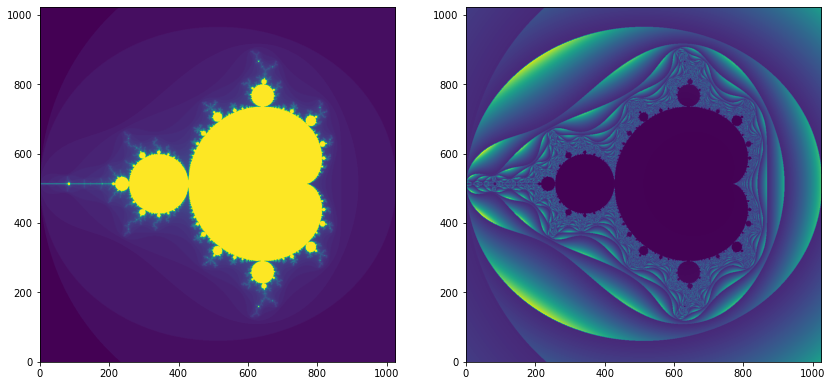

In [158]:
fg = plt.figure(figsize=(14,10))
ax1 = fg.add_subplot(1,2,1)
ax2 = fg.add_subplot(1,2,2)

#plot_extent = (width + 1j * height) * scale
#z1 = center - plot_extent / 2
#z2 = z1 + plot_extent

#ax.imshow(mb_set['Ks']**(1/3), origin='lower', extent=(z1.real, z2.real, z1.imag, z2.imag))
ax1.imshow(mb_set['Ks']**(1/3), origin='lower')
ax2.imshow(mb_set['Zs'], origin='lower')

#ax.set_xlabel("$\Re(c)$")
#ax.set_ylabel("$\Im(c)$")

### jit-compiling Mandelbrot:
- This is pretty prime for `numba.jit()`, we have to make a few changes.
- `numba` cannot compile the `numpy.array()` objects
- I think that is it...

In [162]:
@numba.jit()
#@numba.njit(parallel=True)
def mandelbrotter_jit(re_min=-2.0, im_min=-1.5, re_max=1.0, im_max=1.5, N_x=512, N_y=512, max_iter=256):
#    max_iter = 256
#    width = 256
#    height = 256
#    center = -0.8+0.0j
#    extent = 3.0+3.0j
#    scale = max((extent / width).real, (extent / height).imag)j
    # if given d_re, d_im
    #N_x = int((re_max - re_min)/d_re)
    #N_y = int((im_max - im_min)/d_im)
    d_re = (re_max - re_min)/N_x
    d_im = (im_max - im_min)/N_y
    #
    #print('** DEBUG: ', N_x, N_y)
    #print('** DEBUG: ', d_re, d_im)
    #
    # ** jit() cannot handle the numpy.array(), so we have to do this as Python lists.
    Ks = [[0 for a in range(N_x)] for b in range(N_y)]
    Zs = [[0. for a in range(N_x)] for b in range(N_y)]
    #Ks = numpy.zeros((N_x, N_y), int)
    #Zs = numpy.zeros((N_x, N_y), float)
    #Ks = [[0 for k in range(N_x)] for j in range(N_y)]
    #Zs = [[0. for k in range(N_x)] for j in range(N_y)]
    #
    for j in range(N_y):
        for i in range(N_x):
            #c = center + (i - width // 2 + (j - height // 2)*1j) * scale
            # Note: I make a silly notation mistake with j vs 1*j, that actually works, but 
            #. should probably be avoided.
            c = re_min + d_re*i + 1j*(im_min + d_im*j)
            z = 0. + 0j
            #
            k = 0
            #for k in range(max_iter):
            while k<max_iter and (z*z.conjugate()).real < 4.0:
                #z = z**2 + c
                z = z*z + c
                k+=1
#                if (z * z.conjugate()).real > 4.0:
#                    break
            Ks[j][i] = k
            Zs[j][i] = (z*z.conjugate()).real
        
    #
    #return {'Ks': Ks, 'Zs':Zs}
    return Ks,Zs
      

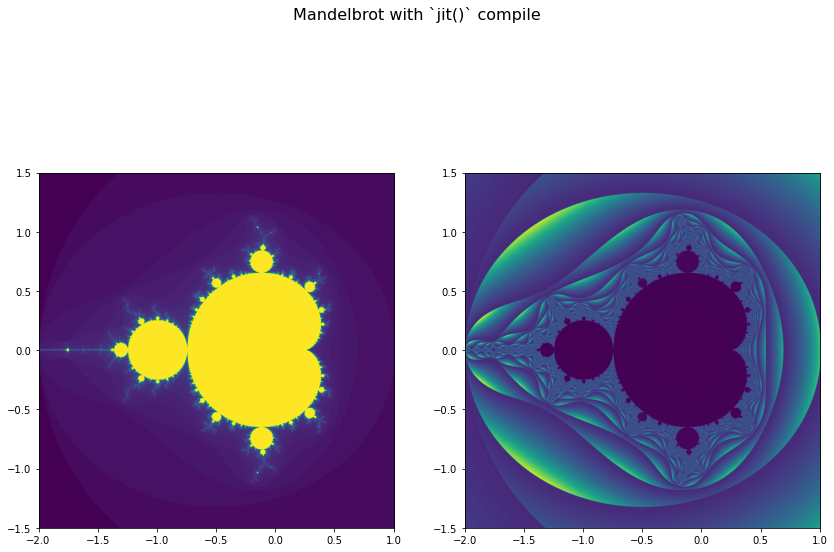

In [163]:
mb_jit = mandelbrotter_jit(N_x=2048, N_y=2048, max_iter=1024, re_min=-2.0, im_min=-1.5, re_max=1.0, im_max=1.5)
#

fg = plt.figure(figsize=(14,10))
ax1 = fg.add_subplot(1,2,1)
ax2 = fg.add_subplot(1,2,2)
#
#plot_extent = (width + 1j * height) * scale
#z1 = center - plot_extent / 2
#z2 = z1 + plot_extent
#
#ax.imshow(mb_set['Ks']**(1/3), origin='lower', extent=(z1.real, z2.real, z1.imag, z2.imag))
ax1.imshow(numpy.array(mb_jit[0])**(1/3), origin='lower', extent=(-2., 1., -1.5, 1.5))
ax2.imshow(numpy.array(mb_jit[1]), origin='lower', extent=(-2., 1., -1.5, 1.5))
tt = plt.suptitle('Mandelbrot with `jit()` compile', size=16)

### Data structures
- We have used the obvious data structure of an $M \times N$ array (`numpy.shape(Zs)=(M,N`)
- For various reasons, we might consider an indexed array, where the $x,y$ coordinates are specified, not implied.
- "Self describing" data structure
- Might be easier to reconstruct if we parallelize
- More foregiving of missing data
- Other things too...

In [102]:

N_x = 512
N_y = 512
#
#@numba.jit()
#@numba.njit(parallel=True)
def mandelbrotter_xyz(re_min=-2.0, im_min=-1.5, re_max=1.0, im_max=1.5, N_x=N_x, N_y=N_y, max_iter=256):
    # Zs = [[x,y,z], ...]
    #
    d_re = (re_max - re_min)/N_x
    d_im = (im_max - im_min)/N_y
    #
    #print('** DEBUG: ', N_x, N_y)
    #print('** DEBUG: ', d_re, d_im)
    #
    # let's see if we can still manage jit():
    KZs = [[re_min + d_re*n_x, im_min + d_im*n_y, 0, 0.] for n_y, n_x in\
           list( itertools.product(range(N_y), range(N_x)) ) ]
    #Zs = [[re_min + d_re*n_x, im_min + d+im*n_y, 0] for n_y, n_x in itertools.product(range(N_y), range(N_x))]
    #
    for m, (x,y,K,z) in enumerate(KZs):
        #c = center + (i - width // 2 + (j - height // 2)*1j) * scale
        c = x + 1j*y
        z = 0. + 0j
        #
        k = 0
        #
        while k<max_iter and (z*z.conjugate()).real < 4.0:
            #z = z**2 + c
            z = z*z + c
            k+=1
            if (z * z.conjugate()).real > 4.0:
                break
        KZs[m][2] = k
        KZs[m][3] = (z*z.conjugate()).real
        
    #
    #return {'Ks': Ks, 'Zs':Zs}
    return KZs

### Vectorized Mandelbrot calculation
- Make a vector
- Iterate the whole thing...


<ipython-input-240-4f79a2e00e52>:22: RuntimeWarning: overflow encountered in multiply
  Zs = Zs*Zs + Cs
<ipython-input-240-4f79a2e00e52>:22: RuntimeWarning: invalid value encountered in multiply
  Zs = Zs*Zs + Cs
<ipython-input-240-4f79a2e00e52>:32: RuntimeWarning: overflow encountered in multiply
  ZZ = numpy.real(mb_v*numpy.conjugate(mb_v))
<ipython-input-240-4f79a2e00e52>:32: RuntimeWarning: invalid value encountered in multiply
  ZZ = numpy.real(mb_v*numpy.conjugate(mb_v))


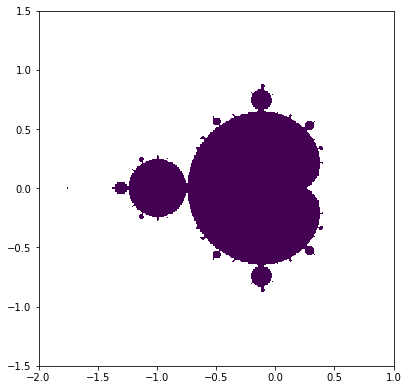

In [240]:
def mandelbrotter_vec_rec(re_min=-2.0, im_min=-1.5, re_max=1.0, im_max=1.5, N_x=512, N_y=512, max_iter=256):
#    max_iter = 256
#    width = 256
#    height = 256
#    center = -0.8+0.0j
#    extent = 3.0+3.0j
#    scale = max((extent / width).real, (extent / height).imag)j
    d_re = (re_max - re_min)/N_x
    d_im = (im_max - im_min)/N_y
    #
    Zs = numpy.zeros((N_y, N_x), dtype='complex128')
#     X,Y = numpy.meshgrid(numpy.arange(re_min, re_max, re_im),
#                          numpy.arange(im_min, im_max, d_im))
    X,Y = numpy.meshgrid(numpy.linspace(re_min, re_max, N_x), numpy.linspace(im_min, im_max, N_y))
    Cs = (X + 1j*Y)
    #Cs = numpy.zeros( (N_y, N_x), dtype='complex128')
    #print('** ', Cs[0][0:10])
    
    #print(f'** \n{X}\n{Y}]\n{Cs}')
    #
    for k in range(max_iter):
        Zs = Zs*Zs + Cs
        #
    return Zs, Cs
    

mb_v, Cs = mandelbrotter_vec_rec(N_x=N_x, N_y=N_y, max_iter=250, re_min=-2.0, im_min=-1.5, re_max=1.0, im_max=1.5)
del ZZ
ZZ = numpy.real(mb_v*numpy.conjugate(mb_v))
#
fg = plt.figure(figsize=(14,10))
ax1 = fg.add_subplot(1,2,1)
#ax1.imshow(ZZ)
ax1.imshow(ZZ, origin='lower', extent=(-2., 1., -1.5, 1.5))


In [232]:
print('** ', Cs.ravel()[0:10])

**  [-2.        -1.5j -1.99412916-1.5j -1.98825832-1.5j -1.98238748-1.5j
 -1.97651663-1.5j -1.97064579-1.5j -1.96477495-1.5j -1.95890411-1.5j
 -1.95303327-1.5j -1.94716243-1.5j]


<ipython-input-241-b438ad0636dd>:25: RuntimeWarning: overflow encountered in multiply
  Zs['z'] = Zs['z']*Zs['z'] + Cs
<ipython-input-241-b438ad0636dd>:25: RuntimeWarning: invalid value encountered in multiply
  Zs['z'] = Zs['z']*Zs['z'] + Cs
<ipython-input-241-b438ad0636dd>:27: RuntimeWarning: overflow encountered in multiply
  Zs['Z'] = numpy.real(Zs['z']*numpy.conjugate(Zs['z']))
<ipython-input-241-b438ad0636dd>:27: RuntimeWarning: invalid value encountered in multiply
  Zs['Z'] = numpy.real(Zs['z']*numpy.conjugate(Zs['z']))
<ipython-input-241-b438ad0636dd>:50: RuntimeWarning: overflow encountered in multiply
  Zs = (mb_vec['z']*numpy.conjugate(mb_vec['z'])).astype(float).reshape(N_y, N_x)
<ipython-input-241-b438ad0636dd>:50: RuntimeWarning: invalid value encountered in multiply
  Zs = (mb_vec['z']*numpy.conjugate(mb_vec['z'])).astype(float).reshape(N_y, N_x)
<ipython-input-241-b438ad0636dd>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  Zs = (mb_ve

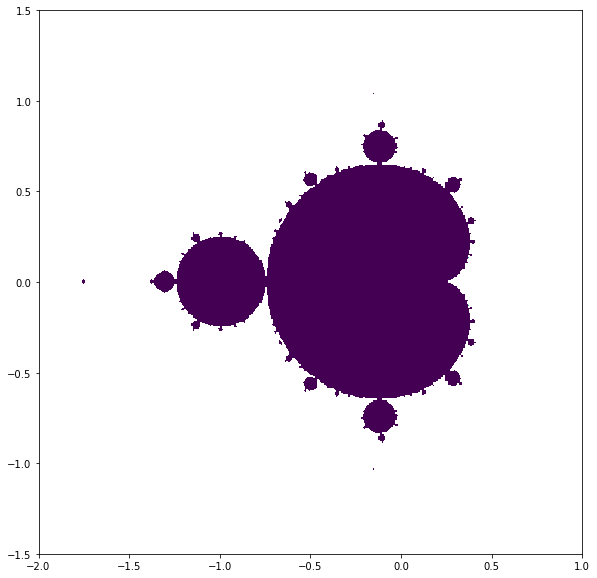

In [241]:
def mandelbrotter_vec(re_min=-2.0, im_min=-1.5, re_max=1.0, im_max=1.5, N_x=512, N_y=512, max_iter=256):
#    max_iter = 256
#    width = 256
#    height = 256
#    center = -0.8+0.0j
#    extent = 3.0+3.0j
#    scale = max((extent / width).real, (extent / height).imag)j
    d_re = (re_max - re_min)/N_x
    d_im = (im_max - im_min)/N_y
    #
    #print('** DEBUG: ', N_x, N_y)
    #print('** DEBUG: ', d_re, d_im)
    #
    # Construcrt an array...
    Zs = numpy.array([(re_min + d_re*n_x, im_min + d_im*n_y, 0.+0j, 0.) for n_y, n_x in\
           list( itertools.product(range(N_y), range(N_x)) ) ], dtype=[('x',float), ('y',float),
                                                                       ('z',complex), ('Z',float)] )
    #Zs = [[re_min + d_re*n_x, im_min + d+im*n_y, 0] for n_y, n_x in itertools.product(range(N_y), range(N_x))]
    #
    #Cs = Zs[:,0] + 1j*Zs[:,1]
    Cs = Zs['x'] + 1j*Zs['y']
    #
    for k in numpy.arange(max_iter):
        #Zs[:,2] = Zs[0:,2]*numpy.conjugate(Zs[0:,2]) + Cs
        Zs['z'] = Zs['z']*Zs['z'] + Cs

    Zs['Z'] = numpy.real(Zs['z']*numpy.conjugate(Zs['z']))
        
    #
    #return {'Ks': Ks, 'Zs':Zs}
    return Zs





mb_vec = mandelbrotter_vec(N_x=N_x, N_y=N_y, max_iter=256, re_min=-2.0, im_min=-1.5, re_max=1.0, im_max=1.5)

fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot(1,1,1)
#ax2 = fg.add_subplot(1,2,2)


#plot_extent = (width + 1j * height) * scale
#z1 = center - plot_extent / 2
#z2 = z1 + plot_extent

#ax.imshow(mb_set['Ks']**(1/3), origin='lower', extent=(z1.real, z2.real, z1.imag, z2.imag))
#Ks = numpy.array([rw[2] for rw in mb_xyz]).reshape(N_y, N_x)
Zs = (mb_vec['z']*numpy.conjugate(mb_vec['z'])).astype(float).reshape(N_y, N_x)

#Zs = mb_vec['Z'].reshape(N_y, N_x)
#Zs[numpy.isnan(Zs)] = 42.
#Zs[Zs<2.] = 0.
#
ax1.imshow(Zs, origin='lower', extent=(-2., 1., -1.5, 1.5))


In [125]:
for rw in mb_vec[0:10]:
    print('** ', [x for x in rw])

**  [(-2+0j), (-1.5+0j), (nan+nanj), (nan+0j)]
**  [(-1.994140625+0j), (-1.5+0j), (nan+nanj), (nan+0j)]
**  [(-1.98828125+0j), (-1.5+0j), (nan+nanj), (nan+0j)]
**  [(-1.982421875+0j), (-1.5+0j), (nan+nanj), (nan+0j)]
**  [(-1.9765625+0j), (-1.5+0j), (nan+nanj), (nan+0j)]
**  [(-1.970703125+0j), (-1.5+0j), (nan+nanj), (nan+0j)]
**  [(-1.96484375+0j), (-1.5+0j), (nan+nanj), (nan+0j)]
**  [(-1.958984375+0j), (-1.5+0j), (nan+nanj), (nan+0j)]
**  [(-1.953125+0j), (-1.5+0j), (nan+nanj), (nan+0j)]
**  [(-1.947265625+0j), (-1.5+0j), (nan+nanj), (nan+0j)]


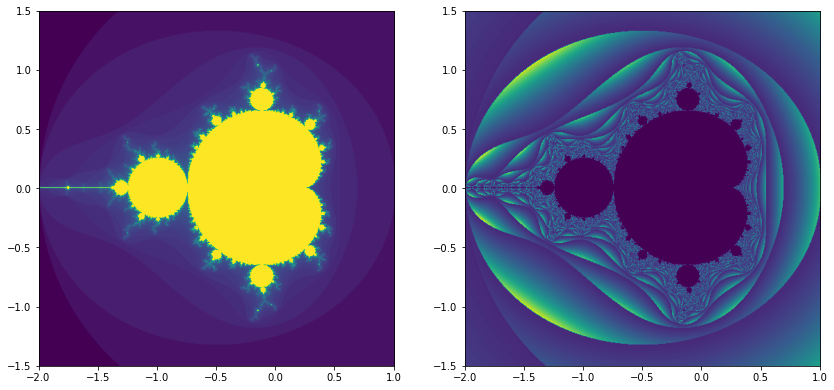

In [110]:
mb_xyz = mandelbrotter_xyz(N_x=N_x, N_y=N_y, max_iter=256, re_min=-2.0, im_min=-1.5, re_max=1.0, im_max=1.5)

fg = plt.figure(figsize=(14,10))
ax1 = fg.add_subplot(1,2,1)
ax2 = fg.add_subplot(1,2,2)

#plot_extent = (width + 1j * height) * scale
#z1 = center - plot_extent / 2
#z2 = z1 + plot_extent

#ax.imshow(mb_set['Ks']**(1/3), origin='lower', extent=(z1.real, z2.real, z1.imag, z2.imag))
Ks = numpy.array([rw[2] for rw in mb_xyz]).reshape(N_y, N_x)
Zs = numpy.array([rw[3] for rw in mb_xyz]).reshape(N_y, N_x)
Zs[Zs<2.] = 0.
#
ax1.imshow(Ks**(1/3), origin='lower', extent=(-2., 1., -1.5, 1.5))
ax2.imshow(Zs, origin='lower', extent=(-2., 1., -1.5, 1.5))


### Parralelizing Mandelbrot
- The most direct approach is probably to break up the domain spatially
- Note that loadbalancing will not be perfect; domains that diverge quickly will finish quickly
- The direct rectangular lattice (2D array) is convenient, but complicates breaking up the problem
  - Restrictive, since current implementation requires rectangular chunks, which might not align with the desired number of processes.
  - potentially difficult to put together.
- Consider a `[[x,y,z], ...]` type data format instead...
- In retrospect, I don't think this is a _great_ example where this data structure makes parallelization easier.
- I think the best approach is to still use a `Pool()` over an array of rectangular subdomains, but using this data structure will make it much easier to reassemble.

### Parallelization: Breaking into subdomains
- Break up domain into $n^2$ subdomains
- Compute subdomains
- View
- Reassemble

#### Stragegy and exercises
- Let's start with the `_jit()` implementation (which uses rectangular arrays); we can also introduce some array assignment notation.
- Note that we have to be careful about integer math on the subdomain boundary pixels
- This complication can be mitigated with a different, maybe indexed possibly less efficient, array structure.
- Consider a Pool() class (or queue() ?). Why?
- What are the (dis-) advantages of using Process() instances?
- For pool, consider and discuss using `map()`, `map_async()`, `apply()`, `apply_async()`, `star_map()`.
- The final task is left to the reader as an exercise.
- Consider other versions of the task that can be parallelized, eg. an assortment of zooms.

** Xs:  [-2. -1.  0.  1.]
** Ys:  [-1.5 -0.5  0.5  1.5]
** [0] -2.0, -1.0, -1.5, -0.5
** [1] -1.0, 0.0, -1.5, -0.5
** [2] 0.0, 1.0, -1.5, -0.5
** [3] -2.0, -1.0, -0.5, 0.5
** [4] -1.0, 0.0, -0.5, 0.5
** [5] 0.0, 1.0, -0.5, 0.5
** [6] -2.0, -1.0, 0.5, 1.5
** [7] -1.0, 0.0, 0.5, 1.5
** [8] 0.0, 1.0, 0.5, 1.5


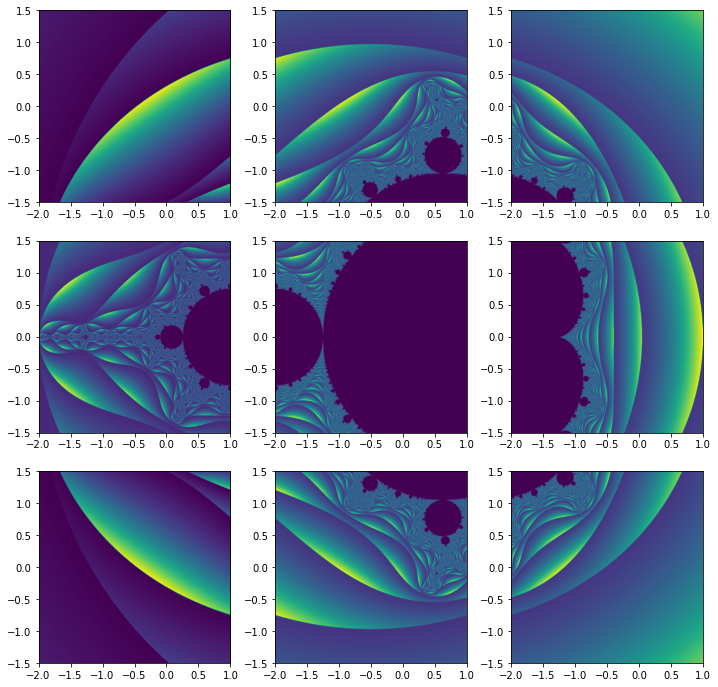

In [52]:
# We see the debate between splitting on the continuum vs discrete pixels.

Re_0 = -2.0
Re_1 = 1.0
Im_0 = -1.5
Im_1 = 1.5
#
N_x = 1024
N_y = 1024
#
n_side = 3
nits = 512
#
# compute and show the subdomains
N_xs = int(N_x/n_side)
N_ys = int(N_y/n_side)
#
Xs = numpy.linspace(Re_0, Re_1, n_side+1)
Ys = numpy.linspace(Im_0, Im_1, n_side+1)
print('** Xs: ', Xs)
print('** Ys: ', Ys)
#
fg = plt.figure(figsize=(12,12))
axes = [fg.add_subplot(n_side, n_side, k+1) for k in range(n_side*n_side)]
fig_map = {0:0}
#
for k, ( (y1,y2), (x1,x2) )in enumerate(itertools.product(zip(Ys[0:-1], Ys[1:]), zip(Xs[0:-1], Xs[1:]))):
    print(f'** [{k}] {x1}, {x2}, {y1}, {y2}')
    mb_jit = mandelbrotter_jit(N_x=N_x, N_y=N_y, max_iter=256, re_min=x1, im_min=y1, re_max=x2, im_max=y2)
    Zs = numpy.array(mb_jit[1])
    Zs[Zs<2.] = 0.
#
    axes[k].imshow(Zs, origin='upper', extent=(-2., 1., -1.5, 1.5))
    

### Exercise: Perform the sub-domain Mandelbroc computaton, and reassembly (Not shown...) in parallel. 
- Consider using `Pool()` with different `map()` and `apply()` methods.
- Is the above model the best way to decompose the job?
- Benefits of different array structures (eg, (N,M) subdomains vs an [[x,y,z],...]  model)
- For the 